In [1]:
import numpy as np
import pickle as pk
import pandas as pd

from PIL import Image, ImageDraw

import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

norm = matplotlib.colors.Normalize(vmin=1, vmax=3)
cmap = matplotlib.cm.get_cmap('viridis')

root = r"C:\tmp\OwnCloud\docs\neuroconnlab\dist_model\git\\"

c:\tmp\tools\Python38\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# plotting functions

In [2]:
from brainspace.utils.parcellation  import map_to_labels, reduce_by_labels
from lib.plotting import infer_colorbar,  paste_centrally, fig2tightPIL
import hcp_utils as hcp
from surfplot import Plot
from neuromaps.datasets import fetch_fslr
import numpy as np
from matplotlib.lines import Line2D


surfaces = fetch_fslr()
lh, rh = surfaces['inflated']

from brainspace.datasets  import load_parcellation



def show_pdata(data, ld = None, is_32k=False, cmap="coolwarm", mw_val=0, outline=None, title=None, outline_cmap = "Reds", plot_kwargs = {}, **kwargs):
  out = data if ld is None else map_to_labels(data, ld, mask=ld!=mw_val, fill=0)
  lcd = hcp.left_cortex_data(out) if not is_32k else out;
  pkw = dict(surf_lh=lh, size=(800, 300), zoom=1.7)
  pkw.update(plot_kwargs)
  p = Plot(**pkw)
  lkw = dict(cmap=cmap, cbar=True);
  lkw.update(kwargs)
  p.add_layer({'left': lcd},  **lkw)
  if not(outline is None):
    out2 = outline if ld is None else map_to_labels(outline, ld, mask=ld!=mw_val, fill=0)
    ocd = hcp.left_cortex_data(out2) if not is_32k else out2;
    p.add_layer({'left': ocd}, cmap=outline_cmap, as_outline=True, cbar=False)
  fig = p.build()
  if not(title is None): fig.axes[0].set_title(title)
  #fig.show()
  return fig


import io, PIL
def fig2pil(fig, pad_inches=-0.0, close=False):
  buf = io.BytesIO()
  fig.savefig(buf, bbox_inches="tight", pad_inches=pad_inches);
  buf.seek(0)
  ret = PIL.Image.open(buf);
  if close: plt.close(fig)
  return ret

def add_cbar(img, data, uc=0.8, lc=0,cmap="viridis", **kwargs):
  jargs = dict(cmap=cmap, aspect=12, shrink=0.18)
  jargs.update(kwargs)
  cb = infer_colorbar(data, **jargs);
  cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=100, format="png", close_fig=1)
  img2 = paste_centrally(img, cbimg)
  return img2

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
def subplot_grid(n_rows, n_cols, cw=7, rh="auto", axis_off=True, flat_axes=False, **kwargs):
  if rh=="auto": rh = cw *0.428;
  fig_args = dict(figsize=((n_cols)*cw, rh*n_rows))
  fig_args.update(kwargs)
  fig, axs = plt.subplots(n_rows,n_cols, **fig_args)
  faxs = axs.flatten()
  if axis_off:
    for i in range(len(faxs)): faxs[i].axis("off");
  return fig, (faxs if flat_axes else axs);

from PIL import Image, ImageDraw 
def image_grid(imgs, rows, cols, size=None, pad=0.01):
    assert len(imgs) <= rows*cols
    imgw, imgh = imgs[0].size if size is None else size
    pw,ph = int(imgw*pad), int(imgh*pad);
    w, h = imgw+pw, imgh+ph;

    grid = PIL.Image.new('RGBA', size=(cols*(w), rows*(h)))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        ew, eh = imgw-img.size[0], 2*(imgh-img.size[1]) # 2* to align at bottom
        #print(w,h,ew,eh)
        #grid.paste(img, box=(i%cols*w, i//cols*h))
        #print((i%cols*w)+0.5*(pw+ew))
        grid.paste(img, box=((i%cols*w)+int(0.5*(pw+ew)), (i//cols*h)+int(0.5*(ph+eh))))
    return grid


def add_patches(ax, cmap="viridis", titles=["real", "predicted", "overlap"], mm=(1,3), **kwargs):
  leg_kwargs = dict(loc='lower center')
  leg_kwargs.update(kwargs)
  cmap = cm.get_cmap(cmap)
  norm = mplcolors.Normalize(vmin=mm[0], vmax=mm[1])
  patches = []
  for i, label in enumerate(titles):
    patches.append(mpatches.Patch(color=cmap(norm(i+1)), label=label))
    ax.legend(handles=patches, **leg_kwargs)

In [4]:
percentile = 90
dice_fn = lambda ground_truth, prediction : np.sum(prediction[ground_truth==1])*2.0 / (np.sum(prediction) + np.sum(ground_truth))

def threshold_map(brain_map, percentile, binary = False, binary_val = 1):
  
  threshold = np.percentile(brain_map, percentile)
  mask = brain_map >= threshold;
  #if binary: return mask;
  brainmap_thres = np.zeros_like(brain_map)
  brainmap_thres[mask] = binary_val if binary else brain_map[mask] 
  return brainmap_thres;

def get_best_differentiated_subj_ids(y_test_pred, y_test, v=False):
  n_subjs= y_test.shape[0]; 
  n_tasks = y_test.shape[2]; 
  
  # dd indxes how well each subject is differentiated from all others on a per task basis
  dd = np.zeros((n_tasks, n_subjs))
  
  for tn in range(n_tasks): 
    corr_mat = np.corrcoef(y_test[:,:,tn],y_test_pred[:,:, tn])
    corr_mat = corr_mat[:n_subjs,n_subjs:]
    #plt.matshow(corr_mat)
  
    diagonal_corrs = np.diag(corr_mat);
    corr_tmp=corr_mat.copy()
    np.fill_diagonal(corr_tmp, np.nan)
    avg_cross_corrs = np.nanmean(corr_tmp,axis=0); 
    dd[tn, :] = (diagonal_corrs- avg_cross_corrs)

  best = np.argsort(dd, axis=1)[:, ::-1]
  best_across_tasks = np.argsort(dd.mean(axis=0))[::-1]
  if v: print("Best 10 differentiated subjects across tasks:", best_across_tasks[:10])
  return dd, best, best_across_tasks

# Load data and info

In [5]:
# get the scores from the regression result data 

regr_data = np.load("results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.small.npy", allow_pickle=1).item()
print(regr_data.keys(), "\n", regr_data['RS-PCA200'].keys())
subjs = regr_data["RS-PCA200"]["sub_test"]

regr_data_sm = np.load("results/scores/linear_regression_scores_and_info_v3.yfull.aa.npy", allow_pickle=1).item()
print(regr_data_sm.keys(), "\n", regr_data_sm['RS-PCA200'].keys())

cdict = {k: v["scoresd"] for k,v in regr_data_sm.items()}
ddict = {k: v["diff_scores_test"] for k,v in regr_data_sm.items()}

c:\tmp\tools\Python38\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dict_keys(['RS-PCA200', 'FS-StructuralMaps']) 
 dict_keys(['scoresd', 'diff_scores_test', 'y_test', 'y_test_pred', 'skr', 'sub_test'])
dict_keys(['RS-PCA200', 'RS-ICA200', 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps']) 
 dict_keys(['scoresd', 'diff_scores_test', 'isubjs', 'skr'])


In [6]:
unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);
ctrtasks = [uc.split("_")[0] for uc in unique_contrasts]
unique_tasks = np.unique(ctrtasks)
contr = {t:n for n,t in enumerate(unique_tasks)}
tasks_ids = [contr[t] for t in ctrtasks]
task_start_x = [np.where(np.array(tasks_ids)==n)[0][0] for n in np.unique(tasks_ids)]
task_mid_x = [np.where(np.array(tasks_ids)==n)[0].mean() for n in np.unique(tasks_ids)]

task_x = np.array([0, 3, 6, 14, 22, 25, 37])-0.3
uniq_tasks = ['EMOT', 'GAMBL', 'LANG', 'MOTOR', 'RELA', 'SOCIAL', 'WM']
#contrast_ids_to_show = [8, 38, 16, 2, 27, 24, 5, 44, 21]
#tnames = ["Lang", "WM2", "Motor Cue", "Emoti", "SocTOM", "Rel", "GRew" ,"WMFace", "MotorT"]
#tnames_mid = ["Lang S-M", "WM2-0", "Motor Cue-Avg", "Emoti Face-Shape", "Social TOM-Rand", "Rel-Match", "Gamble Rew-Pun" ,"WM Face-Av", "Motor T-Avg"]

task_names = ["Language", "Motor", "Emotion", "WM", "Social", "Relational", "Gambling"]
contrast_ids_to_show = [8, 16, 2, 38, 27, 24, 5]

In [7]:
# Get the retest data
fn = "results/retest_hcp40.task_maps47.zscored.npy"
payload = np.load(fn, allow_pickle=1).item()
print(payload.keys())
tdata = payload["test_data"]
rdata = payload["retest_data"]

unique_contrasts2 = payload["info"]["unique_contrasts"]
subjs_retest_subset = payload["info"]["full_rt_subjs"]
zscore = payload["info"]["zscore"]
print("Loaded data:", zscore, tdata.shape)

overlap_subjs = [s for s in subjs if s in subjs_retest_subset ]
print(overlap_subjs)
index_in_big = [list(subjs).index(s) for s in overlap_subjs]
index_in_rts = [list(subjs_retest_subset).index(s) for s in overlap_subjs]
print(len(index_in_big),index_in_big)
print(len(index_in_rts),index_in_rts)

dict_keys(['info', 'test_data', 'retest_data'])
Loaded data: True (40, 29696, 47)
['562345', '599671', '660951']
3 [1, 14, 26]
3 [31, 32, 34]


In [8]:

mean_task_maps = np.load(root + "results/retest_hcp40.test.mean_task_maps47.from_zscored.npy", allow_pickle=1).item()["mean_task_maps"]
print(mean_task_maps.shape)

# Full Task Retest baseline
fn = "results/scores/retest_hcp.40subjs.47tasks.retest_scores.from_zscored.npy"
retest_bl = np.load(fn, allow_pickle=1).item()
print(retest_bl.keys())
sc_retest_corr =retest_bl["mean_corr"]
sc_retest_diff = retest_bl["diff"]
print(sc_retest_corr.shape, sc_retest_diff.shape)

# Full Task baseline when always predicting group averages
fn = "results/scores/retest_hcp.40subjs.47tasks.group_mean_scores.from_zscored.npy"
grp_bl = np.load(fn, allow_pickle=1).item()
print(grp_bl.keys())
sc_gr_corr =grp_bl["mean_corr"]       
print(sc_gr_corr.shape)


(29696, 47)
dict_keys(['mean_corr', 'diff', 'scoresd'])
(47,) (47,)
dict_keys(['mean_corr', 'diff', 'scoresd'])
(47,)


# Group average task maps

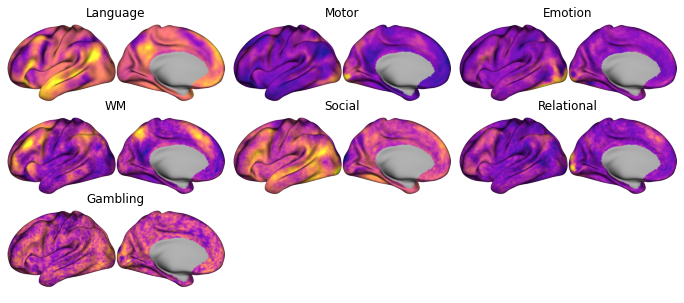

In [12]:
fig, faxs = subplot_grid(3, 3, cw=4, flat_axes=True)

for i in range(len(task_names)):
    cid = contrast_ids_to_show[i]
    tname = task_names[i]

    # First row: just show the task and its rs components
    #v= np.absolute(mean_task_maps[:, cid]).max() *0.85
    v= np.absolute(mean_task_maps[:, cid]).max() *0.85
    vmin,vmax =  mean_task_maps[:, cid].min()*0.85, mean_task_maps[:, cid].max()*0.85
    #f = show_pdata(mean_task_maps[:, cid], cmap="plasma", ld = None, cbar = True, color_range= (vmin,vmax))
    f = show_pdata(mean_task_maps[:, cid], cmap="plasma", ld = None, cbar = False, color_range= (vmin,vmax))
    pimg = fig2pil(f, pad_inches=0); plt.close(f)
    faxs[i].imshow(pimg)
    faxs[i].set_title(tname)

plt.subplots_adjust(wspace=0.04, hspace=0);
#fig.tight_layout()

# Plot barplots

In [13]:
from lib.plotting import plot_corr_scores, plot_bars 
from matplotlib.colors import ListedColormap
from lib.plotting import basic_lines
import cmasher as cmr

In [14]:
cdict["RS-PCA200"].corr.mean(0).shape

(47,)

(7, 47)
(7, 47)


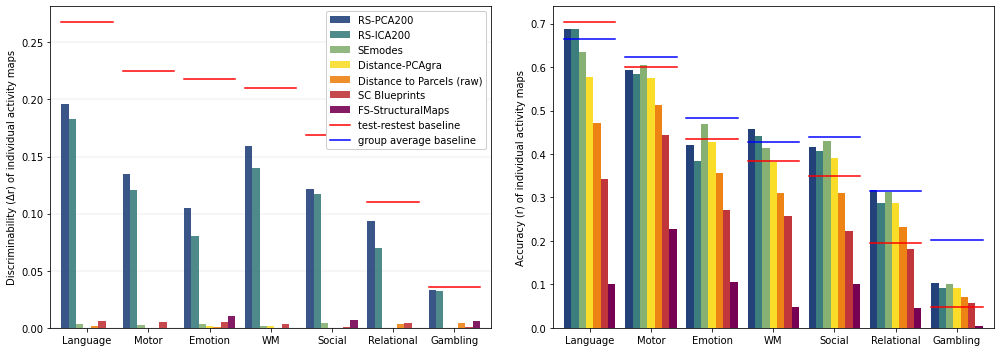

In [16]:
# plot all unimodal regressors
keys = [ 'RS-PCA200', 'RS-ICA200', 'FS-StructuralMaps', 'SC Blueprints', 'Distance to Parcels (raw)', 'Distance-PCAgra', 'SEmodes',  ]
keys = [ 'RS-PCA200', 'RS-ICA200', 'SEmodes', 'Distance-PCAgra', 'Distance to Parcels (raw)', 'SC Blueprints', 'FS-StructuralMaps']
#cmap = ListedColormap(["black", "olive", "yellowgreen", "indianred", "royalblue", "darkorange", "gold", "deepskyblue", "black"])
cmap = cmr.guppy_r
cmap = cmr.wildfire
cmap = cmr.pride #"viridis"


fig, faxs = subplot_grid(1,2 , cw=7, rh=5, flat_axes=False, axis_off=0)
ax = faxs[0]

ax.set_axisbelow(True); ax.grid(axis='y', lw=0.2);
hatches = None
dlab = "Discriminability (Δr) of individual activity maps"
plot_corr_scores(cdict=ddict, keys=keys, sc_retest = sc_retest_diff[contrast_ids_to_show], task_names =None, selected_ids = contrast_ids_to_show, \
     hatches = hatches, ax=ax, cmap=cmap, ylabel=dlab, redby=0.16, alpha=0.9);

#ax = plot_bars(items, keys, xlabels = None , side_by_side=1, ax =ax, alpha=1, redby=0.025, hatches=["//"]*9, cmap=cmap) 
patches = ax.get_legend().get_patches()
patches = patches + basic_lines[:2]
labels = keys + ["test-restest baseline", "group average baseline"]
ax.legend(patches, labels, fontsize="small")
leg = ax.get_legend()
ax.legend(leg.legendHandles, [t._text for t in leg.texts], fontsize="medium", ncol=1, loc='upper right', framealpha=1);
ax.set_xlabel("")
ax.set_xticks(np.arange(len(  task_names)))
ax.set_xticklabels(task_names, ma="right", rotation=0);
ax.set_xlim(-.6, 6.6)

ax = faxs[1]
dlab = "Accuracy (r) of individual activity maps"
plot_corr_scores(cdict=cdict, keys=keys, sc_retest = sc_retest_corr[contrast_ids_to_show], sc_group=sc_gr_corr[contrast_ids_to_show], task_names =None, selected_ids = contrast_ids_to_show, \
     hatches = hatches, ax=ax, cmap=cmap, ylabel=dlab, redby=0.16,alpha=1);
ax.set_xticks(np.arange(len(  task_names)))
ax.set_xticklabels(task_names, ma="right", rotation=0);
ax.get_legend().remove()
ax.set_xlim(-.6, 6.6)
ax.set_xlabel("")

plt.tight_layout(w_pad=2.5)
saveparams=dict(bbox_inches='tight', pad_inches=0, transparent="True", dpi = 300)
#plt.savefig("results/plots/barplot_all_unimodal.predictions.1.spatial_zscore.yfull.png", **saveparams)

In [21]:
print("Correlation:")
for k in keys: print(k, (30-len(k))*" ",  cdict[k].corr.mean(0)[contrast_ids_to_show].round(3))
print("\nDifferentiation:")
for k in keys: print(k, (30-len(k))*" ",  ddict[k][contrast_ids_to_show].round(3))

Correlation:
RS-PCA200                       [0.688 0.594 0.42  0.456 0.417 0.318 0.102]
RS-ICA200                       [0.689 0.583 0.384 0.443 0.408 0.288 0.092]
SEmodes                         [0.636 0.606 0.47  0.414 0.43  0.312 0.102]
Distance-PCAgra                 [0.576 0.575 0.427 0.381 0.39  0.286 0.093]
Distance to Parcels (raw)       [0.471 0.513 0.356 0.31  0.311 0.231 0.071]
SC Blueprints                   [0.341 0.443 0.27  0.258 0.223 0.181 0.057]
FS-StructuralMaps               [0.101 0.228 0.104 0.047 0.101 0.045 0.003]

Differentiation:
RS-PCA200                       [0.196 0.134 0.105 0.159 0.122 0.094 0.033]
RS-ICA200                       [0.182 0.121 0.081 0.14  0.117 0.07  0.032]
SEmodes                         [ 0.003  0.002  0.003  0.002  0.004 -0.    -0.   ]
Distance-PCAgra                 [-0.    -0.     0.001  0.001 -0.001 -0.002 -0.001]
Distance to Parcels (raw)       [ 0.001 -0.004  0.    -0.002 -0.004  0.003  0.004]
SC Blueprints                   [0.0

In [19]:
xx = np.argsort(sc_retest_diff)[::-1]
for i in xx:
    u = "#" if i in contrast_ids_to_show else "";
    print(u, unique_contrasts[i][:20] + " "*(20-len(unique_contrasts[i][:20])), "\t", sc_retest_diff[i])

# LANGUAGE_STORY-MATH  	 0.2679080907682909
 WM_2BK               	 0.26025607478170654
 SOCIAL_TOM           	 0.25648395490415166
 WM_FACE              	 0.2505313319980744
 SOCIAL_RANDOM        	 0.24683884973310005
 GAMBLING_REWARD      	 0.2431878689146366
 GAMBLING_PUNISH      	 0.2430618983598305
 WM_2BK_FACE          	 0.23997655786508015
 WM_BODY              	 0.2292581523386758
 WM_0BK               	 0.22744131876732757
 RELATIONAL_REL       	 0.22453679330306314
# MOTOR_CUE-AVG        	 0.22452020605986708
 RELATIONAL_MATCH     	 0.22239780707338164
 WM_TOOL              	 0.22078510289567635
 MOTOR_AVG            	 0.2177458473857221
# EMOTION_FACES-SHAPES 	 0.21768583357491247
 WM_PLACE             	 0.21289873731689807
 WM_2BK_BODY          	 0.21249619116421545
 WM_2BK_TOOL          	 0.21117917030440445
# WM_2BK-0BK           	 0.20970043491961743
 MOTOR_CUE            	 0.20446925823005557
 WM_2BK_PLACE         	 0.20055484610868266
 LANGUAGE_MATH        	 0.19380930

<ipython-input-24-8b39df13dfe5>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([""] + unimodal_regressors)
<ipython-input-24-8b39df13dfe5>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([""] + unimodal_regressors)


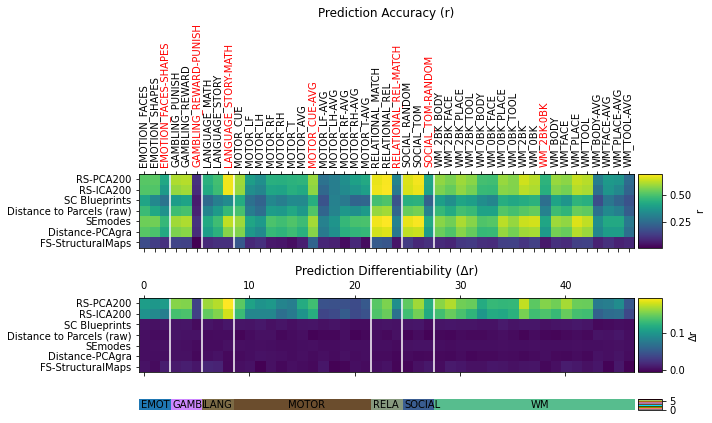

In [24]:
import colorcet as cc
cmap_cat = cc.cm.glasbey_category10 # 
def fxdcolorbar(mappable, *args,**kwargs): from mpl_toolkits.axes_grid1 import make_axes_locatable; last_axes = plt.gca(); ax = mappable.axes; fig = ax.figure; divider = make_axes_locatable(ax);  cax = divider.append_axes("right", size="5%", pad=0.05); cbar = fig.colorbar(mappable, cax=cax, *args,**kwargs); plt.sca(last_axes); return cbar;


unimodal_regressors = ["RS-PCA200","RS-ICA200", 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps']

carr = np.array([regr_data_sm[v]["scoresd"].corr.mean(0) for v in unimodal_regressors])
darr = np.array([regr_data_sm[v]["diff_scores_test"] for v in unimodal_regressors])

fig, axs = plt.subplots(3,1, figsize=(10,6), gridspec_kw={'height_ratios': [3, 3, 0.5]}) 

im = axs[0].matshow(carr, cmap=cmap); fxdcolorbar(im, ax = axs[0], label="r"); axs[0].set_title("Prediction Accuracy (r)");
axs[0].vlines(np.array(task_start_x)-0.5, -0.5, 6.5, colors="white")
axs[0].set_xticks(np.arange(len(unique_contrasts)))
axs[0].set_xticklabels(unique_contrasts, ma="right", rotation=90);
axs[0].set_yticklabels([""] + unimodal_regressors)

for label in np.array(axs[0].get_xticklabels())[contrast_ids_to_show]:
  label.set_color("red")

cmap ="viridis"
im = axs[1].matshow(darr, cmap=cmap); fxdcolorbar(im, ax = axs[1], label="Δr"); axs[1].set_title("Prediction Differentiability (Δr)");
axs[1].vlines(np.array(task_start_x)-0.5, -0.5, 6.5, colors="white")
axs[1].set_yticklabels([""] + unimodal_regressors)

im = axs[2].matshow([tasks_ids], cmap=cmap_cat); cb = fxdcolorbar(im, ax = axs[2]); axs[2].axis('off')
for n, x in enumerate(task_x): axs[2].text(x, 0.3, uniq_tasks[n])
plt.tight_layout()

## Correlations in thresholded peaks

 t statistic maps for the contrast of auditory vs. visual attention were resampled 
 i just always take the highest 90% percentile, which has the advantage that the number of vertices are comparable

In [25]:
# get the test-retest baseline
fn = "results/scores/retest_hcp.40subjs.47tasks.vertexw_acc_across_subjs.from_zscored.npy"
vertex_wise_maps_retest = np.load(fn, allow_pickle=1).item()["vwmaps"]
print(vertex_wise_maps_retest.shape)

(29696, 47)


In [26]:
from tqdm.auto import tqdm
from lib.linear_models import score

scores = {}

for modality in regr_data.keys():
  print("##", modality, end=": ", flush=1)
  y_test = regr_data[modality]['y_test']
  y_test_pred = regr_data[modality]['y_test_pred']
  subjs = regr_data[modality]['sub_test']
  n_subjs, n_tasks = len(subjs), y_test_pred.shape[-1]
  scores[modality] = np.zeros((4,2,n_tasks ))

  ## full
  scoresd, diff_scores_test = score(y_test_pred, y_test);
  scores[modality][0,:,:] = scoresd.corr.mean(0), diff_scores_test

  y_testb = np.zeros((n_subjs, 2970, n_tasks))
  y_test_predb = np.zeros_like(y_testb)

  ## groupROI
  for sn in tqdm(range(n_subjs)):
      for tn in range(n_tasks):
        thres = np.percentile(mean_task_maps[:, tn], 90)
        mask = np.where(mean_task_maps[:, tn] >= thres)[0][:2970]
        y_testb[sn,:, tn], y_test_predb[sn,:, tn] = y_test[sn,mask,tn], y_test_pred[sn,mask,tn]

  scoresd, diff_scores_test = score(y_test_predb, y_testb);
  scores[modality][1,:,:] = scoresd.corr.mean(0), diff_scores_test

  ## rtROI
  for sn in tqdm(range(n_subjs)):
      for tn in range(n_tasks):
        thres = np.percentile(vertex_wise_maps_retest[:, tn], 90)
        mask = np.where(vertex_wise_maps_retest[:, tn] >= thres)[0][:2970]
        y_testb[sn,:, tn], y_test_predb[sn,:, tn] = y_test[sn,mask,tn], y_test_pred[sn,mask,tn]

  scoresd, diff_scores_test = score(y_test_predb, y_testb);
  scores[modality][2,:,:] = scoresd.corr.mean(0), diff_scores_test

  ## ssROI
  for sn in tqdm(range(n_subjs)):
      for tn in range(n_tasks):
        thres = np.percentile(y_test[sn, :, tn], 90)
        mask = np.where(y_test[sn, :, tn] >= thres)[0][:2970]
        y_testb[sn,:, tn], y_test_predb[sn,:, tn] = y_test[sn,mask,tn], y_test_pred[sn,mask,tn]

  scoresd, diff_scores_test = score(y_test_predb, y_testb);
  scores[modality][3,:,:] = scoresd.corr.mean(0), diff_scores_test

## RS-PCA200: 

100%|██████████| 51/51 [00:04<00:00, 12.71it/s]


## FS-StructuralMaps: 

100%|██████████| 51/51 [00:02<00:00, 21.48it/s]


In [30]:
scores.keys()

dict_keys(['RS-PCA200', 'FS-StructuralMaps'])

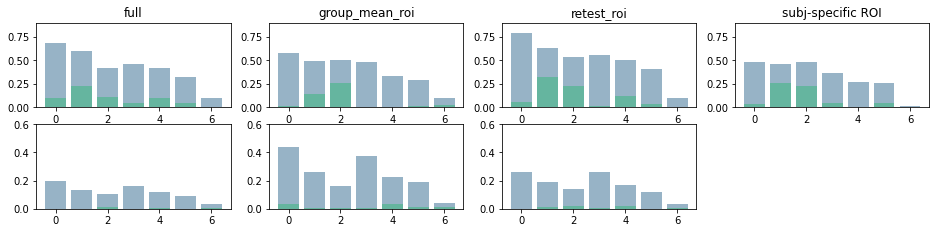

In [28]:
fig, faxs = subplot_grid(2, 4, cw=4, flat_axes=False, axis_off=0)
labels = ["full", "group_mean_roi", "retest_roi", "subj-specific ROI"]
for i in range(4):
  items = [scores[mod][i,0, contrast_ids_to_show] for mod in scores.keys()]
  plot_bars(items, ax= faxs[0,i]); faxs[0,i].set_ylim(0,0.9); faxs[0,i].set_title(labels[i])

  items = [scores[mod][i,1, contrast_ids_to_show] for mod in scores.keys()]
  if i==3: 
    faxs[1,i].axis("off")
    continue
  plot_bars(items, ax= faxs[1,i]); faxs[1,i].set_ylim(0,0.6);
  

# Vertex-wise scores

In [31]:
# get the test-retest baseline
fn = "results/scores/retest_hcp.40subjs.47tasks.vertexw_acc_across_subjs.from_zscored.npy"
vertex_wise_maps_retest = np.load(fn, allow_pickle=1).item()["vwmaps"]
print(vertex_wise_maps_retest.shape)

# get the precomputed scores
fn = "results/scores/linear_regression_scores_and_info_v3.51test_subjs.47tasks.vertexw_acc_across_subjs.from_zscored.yfull.npy"
p = np.load(fn, allow_pickle=1).item()
print(p.keys())
vertex_wise_maps_pred = p['vwmaps']
print(vertex_wise_maps_pred.keys())

(29696, 47)
dict_keys(['vwmaps', 'test_subjs'])
dict_keys(['RS-PCA200', 'RS-ICA200', 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps'])


In [18]:
# this is how they were computed
"""
from lib.stats import comp_corr, compute_scores
# calculate the vertex wise scores
vwcs = {}
for modality in ['RS-PCA200', 'FS-StructuralMaps']:
  y_test = regr_data[modality]['y_test']
  y_test_pred = regr_data[modality]['y_test_pred']
  cs =compute_scores(y_test_pred.transpose(1,2,0), y_test.transpose(1,2,0), score_fn= comp_corr)
  vwcs[modality]=cs;
""";

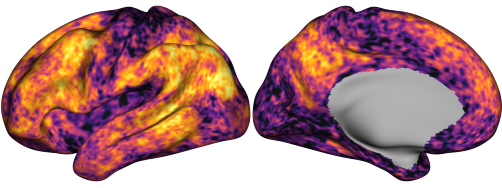

In [34]:
cid =8
fig2pil(show_pdata(vertex_wise_maps_retest[:, cid], cmap = "inferno",color_range = (0,0.9), cbar=False), close=1)

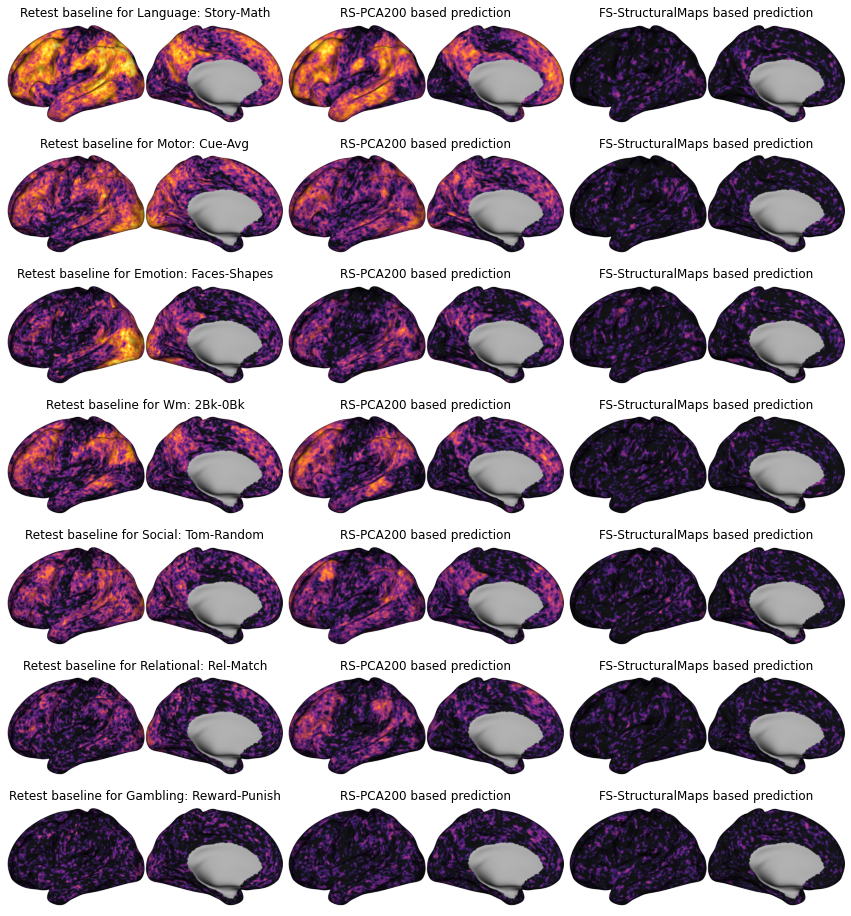

In [35]:
mod2show = ['RS-PCA200', 'FS-StructuralMaps']
fig, axs = subplot_grid(len(contrast_ids_to_show), len(mod2show)+1, cw=5, rh=5*0.48)
#fig.suptitle("Vertex-Wise Scores", fontweight='bold')

for i, cid in enumerate(contrast_ids_to_show):
    axs[i, 0].imshow(fig2pil(show_pdata(vertex_wise_maps_retest[:, cid], cmap = "inferno",color_range = (0,0.9), cbar=False), close=1))
    title=unique_contrasts[cid].replace("_", ": ").lower().title()
    axs[i, 0].set_title("Retest baseline for " + title)

    for j, modality in enumerate(mod2show):
      axs[i, j+1].imshow(fig2pil(show_pdata(vertex_wise_maps_pred[modality][:, cid], cmap = "inferno",color_range = (0,0.9), cbar=False), close=1))
      axs[i, j+1].set_title(modality + " based prediction")

plt.subplots_adjust(wspace=0.02, hspace=0.00);

In [36]:
plt.close("all")

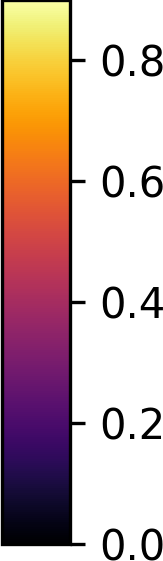

In [37]:
cb = infer_colorbar(None, cminmax=0, vmin=0,vmax=0.9, cmap="inferno", aspect=8, shrink=0.6, orientation="vertical")
cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
cbimg

# Within-parcel scores

In [38]:
from brainspace.utils.parcellation import map_to_labels

# get the test-retest baseline
#fn = "results/scores/retest_hcp.40subjs.47tasks.within_parcel.yfull.from_zscored.npy" # HCPMMP1
fn = "results/scores/retest_hcp.40subjs.47tasks.within_parcel.lausanne.yfull.from_zscored.npy"
p = np.load(fn, allow_pickle=1).item()
print(p.keys())
withinparcel_discr_retest = p["diffs"]


# get the precomputed scores
# using the HCP MMP 1.0 parcellation
fn = "results/scores/linear_regression_scores_and_info_v3.51test_subjs.47tasks.within_parcel.from_zscored.yfull.npy"
p = np.load(fn, allow_pickle=1).item()
hcpmmp1 = p["parcellation29k"]

# lausanne
fn = "results/scores/linear_regression_scores_and_info_v3.51test_subjs.47tasks.within_parcel.lausanne.from_zscored.yfull.npy"
p = np.load(fn, allow_pickle=1).item()
print(p.keys())
withinparcel_discr_pred = p['discr']
parcellation29k = p["parcellation29k"]
parcel_id_to_label = p["parcel_id_to_label"]
print(withinparcel_discr_pred.keys())

dict_keys(['info', 'corrs', 'diffs', 'parcellation29k', 'parcel_id_to_label'])
dict_keys(['corr', 'discr', 'test_subjs', 'parcel_id_to_label', 'parcellation29k'])
dict_keys(['RS-PCA200', 'RS-ICA200', 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps'])


In [39]:
withinparcel_discr_pred["RS-ICA200"].shape

(224, 47)

In [ ]:
# Could be computed via
"""
from tqdm.auto import tqdm
from lib.stats import comp_dice, comp_corr, r2_score
from lib.stats import compute_all_scores, compute_scores, compute_batch_differentiability_score
from lib.linear_models import score

uniq_labels = list(np.unique(parcellation29k));
n_parcels = len(uniq_labels) # all labels in the left hemisphere
n_tasks = y_test_pred.shape[-1]; 

corrs = np.zeros((n_parcels, n_tasks))
diffs = np.zeros((n_parcels, n_tasks))

#pbar = tqdm(list(hcp.mmp.labels.items()), total=n_parcels)
#for v, label in pbar:

pbar = tqdm(enumerate(uniq_labels), total=n_parcels)
for i, label_val in pbar:
    continue;
    label = "" if parcel_id_to_label is None else parcel_id_to_label[label_val]
    mask = parcellation29k == label_val
    pbar.update()
    pbar.set_postfix_str(f"#{label_val} {label}, {mask.sum()}")
    if mask.sum()< 1: continue;
    scoresd, diff_scores_test = score(y_test_pred[:, mask, :], y_test[:, mask, :]);
    corrs[i, :] = scoresd.corr.mean(axis=0)
    diffs[i, :] = diff_scores_test
"""

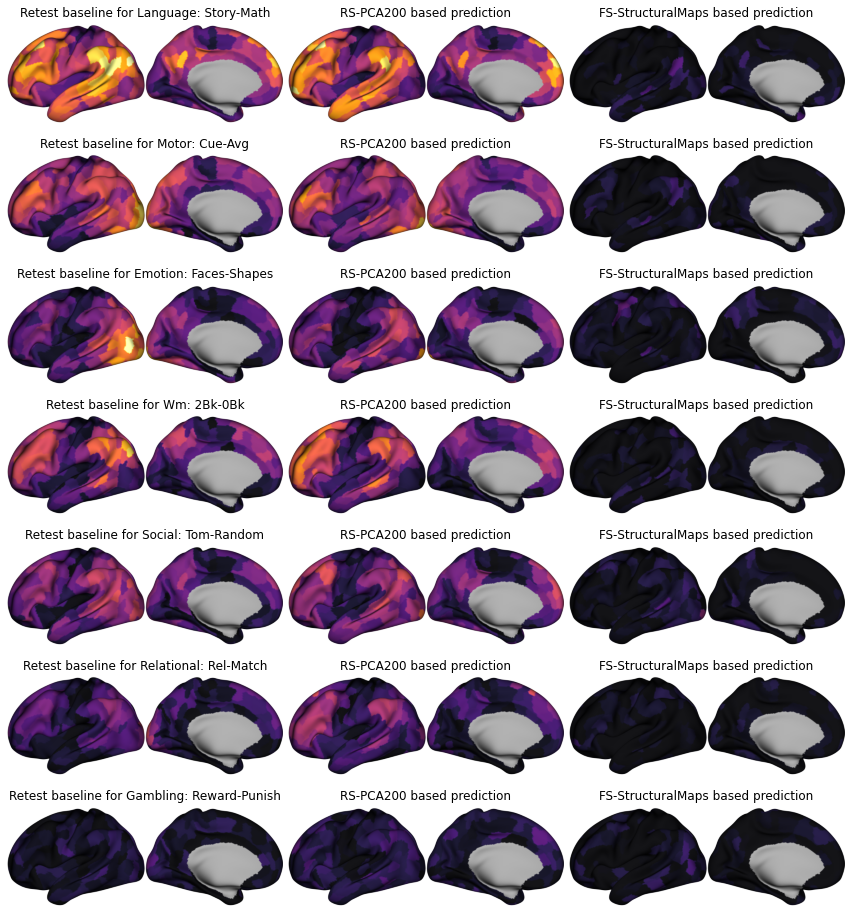

In [41]:
# Plotting discriminability for each parcel-wise model (vs test-retest baseline)

mod2show = ['RS-PCA200', 'FS-StructuralMaps']
fig, axs = subplot_grid(len(contrast_ids_to_show), len(mod2show)+1, cw=5, rh=5*0.48) #0.6
#fig.suptitle("Within parcel scores", fontweight='bold')

for i, cid in enumerate(contrast_ids_to_show):

    xdata = map_to_labels(withinparcel_discr_retest[:, cid], parcellation29k)
    axs[i, 0].imshow(fig2pil(show_pdata( xdata, cmap = "inferno", color_range = (0,0.6), cbar=False), close=1))
    title=unique_contrasts[cid].replace("_", ": ").lower().title()
    axs[i, 0].set_title("Retest baseline for " + title)

    for j, modality in enumerate(mod2show):
      xdata = map_to_labels(withinparcel_discr_pred[modality][:, cid], parcellation29k)
      axs[i, j+1].imshow(fig2pil(show_pdata(xdata, cmap = "inferno", color_range = (0,0.6), cbar=False), close=1))
      axs[i, j+1].set_title(modality + " based prediction")

#plt.subplots_adjust(wspace=0.04, hspace=0.01);
plt.subplots_adjust(wspace=0.02, hspace=0.00);

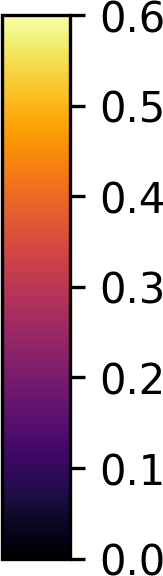

In [42]:
cb = infer_colorbar(None, cminmax=0, vmin=0,vmax=0.6, cmap="inferno", aspect=8, shrink=0.6, orientation="vertical")
cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
cbimg

In [43]:
plt.close("all")

# Combined PCA figure

In [49]:
def add_cbar(img, data, uc=0.8, lc=0,cmap="viridis", force_ticks=False, **kwargs):
  jargs = dict(cmap=cmap, aspect=12, shrink=0.18)
  jargs.update(kwargs)
  cb = infer_colorbar(data, **jargs);
  if not (force_ticks is False):
    #v = np.abs(data).max();
    tick_vals = np.round([data.min(), data.max()], 2) if force_ticks==True else force_ticks;
    print(tick_vals)
    cb.set_ticks(tick_vals, labelsize=100); 
    cb.ax.tick_params(labelsize=12) 
    #cb.ax.get_xticklabels()[0].set_horizontalalignment('left')  
    #cb.ax.get_xticklabels()[-1].set_horizontalalignment('right')
  cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=100, format="png", close_fig=1)
  img2 = paste_centrally(img, cbimg, lc=lc, uc=uc)
  return img2



In [ ]:
modality='RS-PCA200'

fn = "results/scores/linear_regression_scores_and_info_v3.51test_subjs.47tasks.vertexw_acc_across_subjs.from_zscored.yfull.npy"
vertex_wise_maps_test_full = np.load(fn, allow_pickle=1).item()["vwmaps"]

group_map_thres = threshold_map(mean_task_maps[:, tn], percentile, binary=1, binary_val=1)


fn = "results/scores/linear_regression_scores_and_info_v3.51test_subjs.47tasks.within_parcel.lausanne.from_zscored.yfull.npy"
p = np.load(fn, allow_pickle=1).item()
print(p.keys())
withinparcel_discr_pred = p['discr']
parcellation29k = p["parcellation29k"]
parcel_id_to_label = p["parcel_id_to_label"]
print(withinparcel_discr_pred.keys())

dict_keys(['corr', 'discr', 'test_subjs', 'parcel_id_to_label', 'parcellation29k'])
dict_keys(['RS-PCA200', 'RS-ICA200', 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps'])


In [43]:
"""from tqdm.auto import tqdm
from lib.stats import comp_dice, comp_corr, r2_score
from lib.stats import compute_all_scores, compute_scores, compute_batch_differentiability_score
from lib.linear_models import score

y_test_pred = regr_data["RS-PCA200"]["y_test_pred"]
y_test = regr_data["RS-PCA200"]["y_test"]

uniq_labels = list(np.unique(parcellation29k));
n_parcels = len(uniq_labels) # all labels in the left hemisphere
n_tasks = y_test_pred.shape[-1]; 

corrs = np.zeros((n_parcels, n_tasks))
diffs = np.zeros((n_parcels, n_tasks))

#pbar = tqdm(list(hcp.mmp.labels.items()), total=n_parcels)
#for v, label in pbar:

pbar = tqdm(enumerate(uniq_labels), total=n_parcels)
for i, label_val in pbar:
    label = "" if parcel_id_to_label is None else parcel_id_to_label[label_val]
    mask = parcellation29k == label_val
    pbar.update()
    pbar.set_postfix_str(f"#{label_val} {label}, {mask.sum()}")
    if mask.sum()< 1: continue;
    scoresd, diff_scores_test = score(y_test_pred[:, mask, :], y_test[:, mask, :]);
    corrs[i, :] = scoresd.corr.mean(axis=0)
    diffs[i, :] = diff_scores_test"""

100%|██████████| 224/224 [06:19<00:00,  1.69s/it, #224.0 insula_7, 96]                 


[-2.64  2.19]
[0.01 0.59]
[-0.41  0.88]


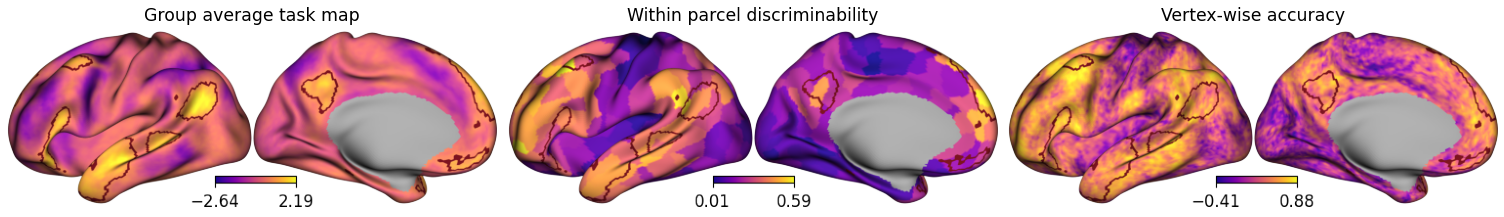

In [50]:
tn= 8
percentile=90
group_map_thres = threshold_map(mean_task_maps[:, tn], percentile, binary=1, binary_val=1)

colomap="plasma"
imgs = []
xdata= mean_task_maps[:, tn]
f = show_pdata(xdata, cmap=colomap, cbar=None, outline=group_map_thres)
img= add_cbar(fig2pil(f, close=1), xdata, uc=0.8, lc=0, cmap=colomap , force_ticks=True)
imgs.append(img)

#diff_data = map_to_labels(diffs[:,tn], parcellation29k)
diff_data = map_to_labels(withinparcel_discr_pred[modality][:, tn], parcellation29k)
f = show_pdata(diff_data, cmap=colomap, cbar=None, outline=group_map_thres)
img = add_cbar(fig2pil(f, close=1), diff_data, uc=0.8, lc=0, cmap=colomap, force_ticks=True )
imgs.append(img)

vw_data = vertex_wise_maps_test_full[modality][:,tn]
f = show_pdata(vw_data, cmap=colomap, cbar=None, outline=group_map_thres);
img = add_cbar(fig2pil(f, close=1), vw_data, uc=0.8, lc=0, cmap=colomap, force_ticks=True)
imgs.append(img)

fig, axs = subplot_grid(1,3, cw=7)
labels = ["Group average task map", "Within parcel discriminability", "Vertex-wise accuracy"]

for i in range(3):
  axs[i].imshow(imgs[i])
  axs[i].set_title(labels[i], size="xx-large")

plt.subplots_adjust(wspace=0.04, hspace=-0.3);
plt.tight_layout()
fig2pil(fig);

In [51]:
plt.close("all")